In [43]:
from datetime import datetime
import os
import numpy as np
import pandas as pd
from als import ALSModel
from utils import validation, train, batch_mapk
import pickle
import scipy 
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(42)

In [2]:
import implicit

/Users/sebbyzhao/Library/Caches/pypoetry/virtualenvs/recsys-HtsDc_SN-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%load_ext autoreload
%autoreload 2

## Data Preprocessing ##

In [ ]:
# Referenced https://github.com/storieswithsiva/Movie-Recommendation-Netflix/blob/master/Uploading%20Movie%20Recommendation%20Netflix.ipynb

In [ ]:
start = datetime.now()
if not os.path.isfile('../data/archive/data.csv'):
    # Create a file 'data.csv' before reading it
    # Read all the files in netflix and store them in one big file('data.csv')
    # reading from each of the four files and appending each rating to a global file 'train.csv'
    data = open('../data/archive/data.csv', mode='w')
    
    row = list()
    files=['../data/archive/combined_data_1.txt','data/archive/combined_data_2.txt', 
           '../data/archive/combined_data_3.txt', 'data/archive/combined_data_4.txt']
    for file in files:
        print("Reading ratings from {}...".format(file))
        with open(file) as f:
            for line in f: 
                del row[:]
                line = line.strip()
                if line.endswith(':'):
                    # All below are ratings for this movie, until another movie appears.
                    movie_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movie_id)
                    data.write(','.join(row))
                    data.write('\n')
        print("Done.\n")
    data.close()
print('Time taken :', datetime.now() - start)

In [ ]:
print("creating the dataframe from data.csv file..")
df = pd.read_csv('../data/archive/data.csv', sep=',', 
                       names=['movie', 'user','rating','date'])
df.date = pd.to_datetime(df.date)
print('Done.\n')

In [ ]:
df.head()

In [ ]:
df.columns

In [ ]:
df['id'] = df.index
df

In [ ]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",df.shape[0])
print("Total No of Users   :", len(np.unique(df.user)))
print("Total No of movies  :", len(np.unique(df.movie)))

In [ ]:
# Keep only users who rated at least 20 movies
df = df.groupby("user").filter(lambda x: len(x) >= 20)
len(np.unique(df.user))

In [ ]:
# Create training and validation sets
# Keep 10 random ratings of each user for validation
valid = df.groupby('user').apply(lambda x: x.sample(n=10, random_state=42))

In [ ]:
valid = valid.reset_index(drop=True)
valid

In [ ]:
train = df[~df.id.isin(valid.id)]
train

In [ ]:
train.to_csv('../data/archive/train.csv', index=False, header=False)
valid.to_csv('../data/archive/valid.csv', index=False, header=False)

In [32]:
train = pd.read_csv('../data/archive/train.csv', names=['movie', 'user', 'rating', 'date', 'id'])
valid = pd.read_csv('../data/archive/valid.csv', names=['movie', 'user', 'rating', 'date', 'id'])

In [ ]:
valid.head()

In [ ]:
# This is way too large to do calculations on. Let's reduce to 1000 users.

In [33]:
users = np.random.choice(valid['user'].unique(), size=1000, replace=False)

In [34]:
train[train['user'].isin(users)].to_csv('../data/archive/train_1000.csv', index=False, header=False)
valid[valid['user'].isin(users)].to_csv('../data/archive/valid_1000.csv', index=False, header=False)

## Script Proper ##

In [6]:
train_data = pd.read_csv('../data/archive/train_1000.csv', names=['movie', 'user', 'rating', 'date', 'id'])
valid_data = pd.read_csv('../data/archive/valid_1000.csv', names=['movie', 'user', 'rating', 'date', 'id'])

In [7]:
valid_data

,movie,user,rating,date,id
0,14218,609,3,2005-05-04,78270268
1,15578,609,3,2005-05-04,87689076
2,15393,609,4,2005-05-04,86457259
3,6994,609,4,2005-05-04,39647242
4,3274,609,1,2005-05-04,16868285
...,...,...,...,...,...
9995,13103,2646451,4,2004-01-22,72683585
9996,1180,2646451,4,2004-02-11,6042131
9997,516,2646451,4,2004-11-09,2837387
9998,3293,2646451,2,2005-04-28,17115028


In [8]:
guarantee_items = pd.concat([pd.DataFrame([[i, -1, -1, -1, -1]], columns=['movie', 'user', 'rating', 'date', 'id']) for i in np.unique(np.append(train_data['movie'].unique(), valid_data['movie'].unique()))],ignore_index=True)
guarantee_items

,movie,user,rating,date,id
0,2,-1,-1,-1,-1
1,3,-1,-1,-1,-1
2,5,-1,-1,-1,-1
3,6,-1,-1,-1,-1
4,8,-1,-1,-1,-1
...,...,...,...,...,...
11571,17763,-1,-1,-1,-1
11572,17764,-1,-1,-1,-1
11573,17768,-1,-1,-1,-1
11574,17769,-1,-1,-1,-1


In [9]:
train_data = pd.concat([train_data, guarantee_items], ignore_index=True)
train_data.head()

,movie,user,rating,date,id
0,2,2345723,4,2004-12-26,658
1,3,360757,3,2005-10-21,1620
2,3,414236,4,2005-10-11,1901
3,3,1187765,4,2003-05-07,2033
4,3,524628,4,2003-03-13,2043


In [10]:
valid_data = pd.concat([valid_data, guarantee_items], ignore_index=True)
valid_data.head()

,movie,user,rating,date,id
0,14218,609,3,2005-05-04,78270268
1,15578,609,3,2005-05-04,87689076
2,15393,609,4,2005-05-04,86457259
3,6994,609,4,2005-05-04,39647242
4,3274,609,1,2005-05-04,16868285


In [11]:
# Create watch matrix
watch_matrix = pd.pivot_table(data=train_data, index='user', columns='movie', values='rating', fill_value=0)
watch_matrix = watch_matrix.applymap(lambda x: 1 if x > 0 else 0)
watch_matrix = watch_matrix.drop(-1, axis=0)
watch_matrix

movie,2,3,5,6,8,12,13,15,16,17,...,17758,17759,17760,17761,17762,17763,17764,17768,17769,17770
user,,,,,,,,,,,,,,,,,,,,,
609,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3984,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
13839,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14301,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14358,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2643191,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2643233,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2644283,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# Watch matrix validation
watch_matrix_validation = pd.pivot_table(data=valid_data, index='user', columns='movie', values='rating', fill_value=0)
watch_matrix_validation = watch_matrix_validation.applymap(lambda x: 1 if x > 0 else 0)
watch_matrix_validation = watch_matrix_validation.drop(-1, axis=0)
watch_matrix_validation

movie,2,3,5,6,8,12,13,15,16,17,...,17758,17759,17760,17761,17762,17763,17764,17768,17769,17770
user,,,,,,,,,,,,,,,,,,,,,
609,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3984,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13839,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14301,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14358,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2643191,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2643233,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2644283,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
def random_classification_noise(watch_matrix, p):
    """
    watch_matrix: watch matrix of watched or not
    p: probability of disliking an interacted with item
    """
    # Create a copy of the watch matrix
    watch_matrix_noisy = watch_matrix.copy()
    
    # For each user, randomly select p% of their interacted with items and set them to 0
    watch_matrix_noisy = watch_matrix_noisy.applymap(lambda x: -1 if x == 1 and np.random.random() < p else x)

    return watch_matrix_noisy.values

In [14]:
# Generate preference matrix based on simulation for validation dataset.
# Start training for 20 epochs

In [15]:
random_classification_noise(watch_matrix_validation, 0.1)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [16]:
watch_matrix_validation.values.shape

(1000, 11576)

In [17]:
watch_matrix.values.shape

(1000, 11576)

In [18]:
watch_matrix_csr = scipy.sparse.csr_matrix(watch_matrix.values)

In [19]:
def convert_to_index_lst(matrix):
    return [list(np.where(row == 1)[0]) for row in matrix]

In [20]:
true_prefs = convert_to_index_lst(random_classification_noise(watch_matrix_validation, 0.1))

In [21]:
proxy_prefs = convert_to_index_lst(watch_matrix_validation.values)

In [26]:
proxy_losses, true_losses = [], []
def validation_hook(solver, epoch, elapsed_time, progress):
    # print(solver.user_factors.shape)
    # print(solver.item_factors.shape)
    recommendations = solver.recommend(np.arange(solver.user_factors.shape[0]), watch_matrix_csr, filter_already_liked_items=True, N=10)[0]
    #FIXME: This should actually be the indices of the items
    global proxy_prefs
    global true_prefs
    proxy_loss, true_loss = batch_mapk(recommendations, proxy_prefs, true_prefs)
    proxy_losses.append(proxy_loss)
    true_losses.append(true_loss)
    # Calculate validation loss
    

In [24]:
model = implicit.als.AlternatingLeastSquares(factors=100, calculate_training_loss=True, iterations=10)
model.fit(watch_matrix_csr, callback=validation_hook)

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:01<00:11,  1.26s/it, loss=0.00997]

(0.04545674603174612, 0.04328965183295554)


 20%|██        | 2/10 [00:03<00:11,  1.44s/it, loss=0.00794]

(0.06784817460317451, 0.06480547351347954)


 30%|███       | 3/10 [00:04<00:10,  1.52s/it, loss=0.00741]

(0.07453206349206343, 0.07140604072184444)


 40%|████      | 4/10 [00:06<00:09,  1.56s/it, loss=0.00722]

(0.07576313492063493, 0.07314631456286225)


 50%|█████     | 5/10 [00:08<00:07,  1.60s/it, loss=0.00712]

(0.07565781746031744, 0.07319750692869759)


 60%|██████    | 6/10 [00:09<00:06,  1.61s/it, loss=0.00707]

(0.07641436507936511, 0.07399812074829948)


 70%|███████   | 7/10 [00:11<00:04,  1.61s/it, loss=0.00704]

(0.07690027777777789, 0.07431503511589835)


 80%|████████  | 8/10 [00:12<00:03,  1.60s/it, loss=0.00702]

(0.07705916666666669, 0.07431539887251208)


 90%|█████████ | 9/10 [00:14<00:01,  1.62s/it, loss=0.00701]

(0.07728396825396824, 0.07463593726379444)


100%|██████████| 10/10 [00:16<00:00,  1.65s/it, loss=0.007]  

(0.07733174603174606, 0.07437612244897969)


[0.009969112783726319,
 0.007939922529638859,
 0.007413441399472809,
 0.007219799514104095,
 0.007123782633020261,
 0.007070842644408495,
 0.007040110278585718,
 0.007021102617544681,
 0.0070085848854418275,
 0.006999884910068832]

In [36]:
res = []

for p in [0.25, 0.5, 0.75]:
    proxy_losses = []
    true_losses = []
    true_prefs = convert_to_index_lst(random_classification_noise(watch_matrix_validation, p))
    
    model = implicit.als.AlternatingLeastSquares(factors=100, calculate_training_loss=True, iterations=100)
    train_losses = model.fit(watch_matrix_csr, callback=validation_hook)
    res.append((p, train_losses, proxy_losses, true_losses))

with open('../data/archive/results.txt', 'wb') as f:
    pickle.dump(res, f)


100%|██████████| 100/100 [02:48<00:00,  1.69s/it, loss=0.00696]


Text(0, 0.5, 'MAP@K')

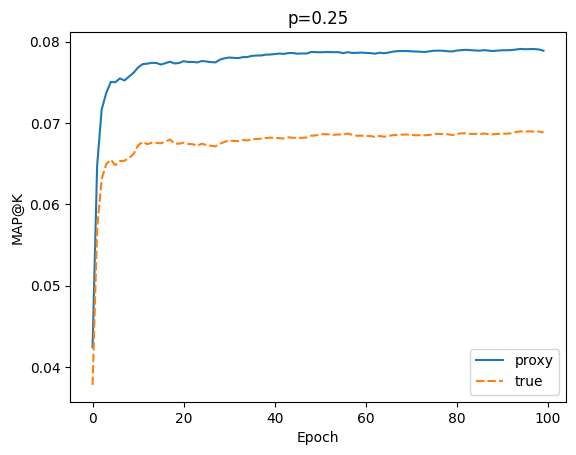

In [46]:
p, train_losses, proxy_losses, true_losses = res[0]
df = pd.DataFrame({'proxy': proxy_losses, 'true': true_losses})
sns.lineplot(data=df)
plt.title(f"p={p}")
plt.xlabel("Epoch")
plt.ylabel("MAP@K")


Text(0, 0.5, 'MAP@K')

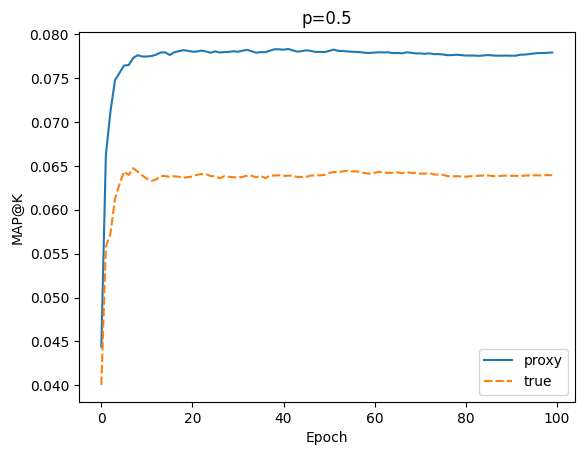

In [47]:
p, train_losses, proxy_losses, true_losses = res[1]
df = pd.DataFrame({'proxy': proxy_losses, 'true': true_losses})
sns.lineplot(data=df)
plt.title(f"p={p}")
plt.xlabel("Epoch")
plt.ylabel("MAP@K")


Text(0, 0.5, 'MAP@K')

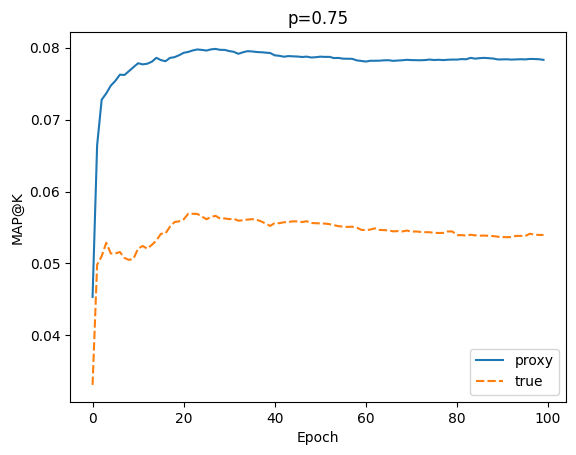

In [48]:
p, train_losses, proxy_losses, true_losses = res[2]
df = pd.DataFrame({'proxy': proxy_losses, 'true': true_losses})
sns.lineplot(data=df)
plt.title(f"p={p}")
plt.xlabel("Epoch")
plt.ylabel("MAP@K")



In [49]:
proxy_losses = []
true_losses = []
true_prefs = convert_to_index_lst(random_classification_noise(watch_matrix_validation, 0.9))

model = implicit.als.AlternatingLeastSquares(factors=100, calculate_training_loss=True, iterations=100)
train_losses = model.fit(watch_matrix_csr, callback=validation_hook)

100%|██████████| 100/100 [02:49<00:00,  1.69s/it, loss=0.00696]


Text(0, 0.5, 'MAP@K')

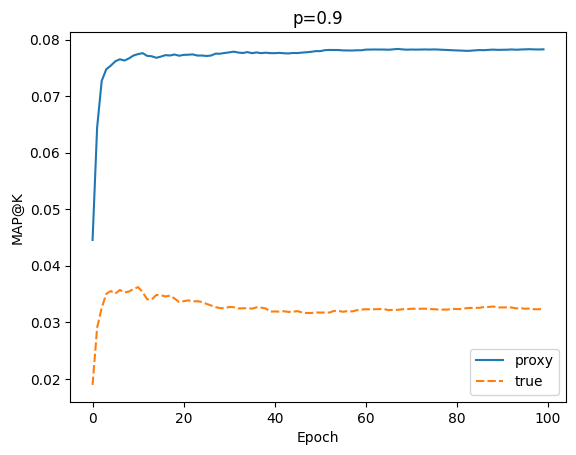

In [50]:
df = pd.DataFrame({'proxy': proxy_losses, 'true': true_losses})
sns.lineplot(data=df)
plt.title(f"p={0.9}")
plt.xlabel("Epoch")
plt.ylabel("MAP@K")